# Numerical model of a growing trilayer - Visualization and data analysis

This notebook serves as a comprehensive guide to showcase and describe the datasets generated by the script `script_buckling_simulation`. The focus is to elucidate the methodologies employed in the data processing steps and to demonstrate how these datasets are leveraged to produce the figures for the manuscript [...].

## One simulation

### The output data

The simulation script `script_buckling_simulation` creates an output directory, in which the following files contain the saved pieces of information regarding the simulation:

* README.md: This markdown file provides essential information about the simulation. It includes documentation on the simulation parameters and details about the convergence of the solver, giving insight into the numerical stability and accuracy of the simulation results.

* simulation_parameter.json: The JSON file contains structured data regarding the simulation parameters.

* simulation_data.h5: This HDF5 file stores the FeniCS objects corresponding to the raw simulation data, including the mesh details and deformation data.

* simulation_metadata.pkl: This Pickle file contains all the additional information that can not be stored easily in the .h5 file (time-steps, information about the solver convergence, information about the buckling monitoring, ...).

* bilayer_deformation.pdf and monitoring_buckling.pdf: Both PDF documents serve as visual outputs that allow the observation of the tissue deformations and the progression of buckling over time. The progression of the buckling is followed by monitoring the variation of the height of the tissue and the variation of surface curvatures (from the inner and outer layers).

In [20]:
from utils.trilayer_analysis import read_simulation_data

In [21]:
folder = 'data/SimulationOutput_E[1000000.0, 1, 10000.0, 1000000.0]_C[0.01, 0.1, 0.01, 0.01]_dg[0, 0, 0.1, 0]_L10_h[4.8, 0.1]_cs0.2_CI0.0001_N3/'
example_file = 'simulation_data.h5'

# - To read the simulation data, you need to give the .h5 file path 
mesh, cdata, bdata, solutions, mesh_metadata, time_steps, data_monitoring = read_simulation_data(folder + example_file)

The function `read_simulation_data` reads all the raw data from the .h5 file and .pkl file : 
* mesh (fe.Mesh) : the tissue mesh
* cdata (fe.MeshFunctionSizet) : defined the sub-domains (inner, outer, mesophyl, edge)
* bdata (fe.MeshFunctionSizet) : defined the sub-boundaries (none in our case)
* solutions (dict of fe.Function) : the deformation field at each time-steps
* mesh_metadata (dict): sub-domains / sub-boundaries names
* time_steps (list) : list of the time-steps
* data_monitoring (dict of dict) : variation of height (`dH`) and surface curvatures (`kappa_inner`, `kappa_outer`, `kappa_middle`) at each time-steps

In [22]:
# Display the parameters of the simulation
import json
with open(folder + 'simulation_parameter.json') as f:
    data = json.load(f)
    
    for keys, val in data.items():
        print(keys, '-->',  val)

L --> 10
layer_heights --> [4.8, 0.1]
cs --> 0.2
Nsteps --> 3
tmax --> 3
E --> [1000000.0, 1, 10000.0, 1000000.0]
C --> [0.01, 0.1, 0.01, 0.01]
nu --> [0.49, 0.49, 0.49, 0.49]
g --> [1, 1, 1, 1]
dg --> [0, 0, 0.1, 0]
imperfection --> 0
geo_pertub_norm --> 0
CI_perturbation --> 0.0001
threshold_height --> 0.1
dirname --> SimulationOutput_E[1000000.0, 1, 10000.0, 1000000.0]_C[0.01, 0.1, 0.01, 0.01]_dg[0, 0, 0.1, 0]_L10_h[4.8, 0.1]_cs0.2_CI0.0001
root_name --> results
N --> 3


### Visualisation

The different FeniCS objects (`mesh`, `cdata`, `solutions`,...) can be visualized using `plot_mesh_and_solutions`.

In [23]:
import pyvista as pv
from utils.trilayer_visu import plot_mesh_and_solutions

some_solutions = {t: v for t, v in solutions.items() if t > 0} # remove t=0
pl = plot_mesh_and_solutions(mesh, cdata, some_solutions)

Widget(value='<iframe src="http://localhost:34647/index.html?ui=P_0x7fd207c81730_11&reconnect=auto" class="pyv…

The variation of shape of the tissue induced by the deformation fields can be followed using `plot_list_deformation`.

In [24]:
from utils.trilayer_visu import plot_list_deformation

pl = plot_list_deformation(mesh, cdata, solutions, Ncol=4)

Widget(value='<iframe src="http://localhost:34647/index.html?ui=P_0x7fd1dd0bda00_17&reconnect=auto" class="pyv…

The information contained in `data_monitoring`, corresponding to the buckling observation, can be displayed using `plot_buckling_monitoring`.

/home/akiss/git-inria/growth_buckling/utils/trilayer_visu.py:360: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


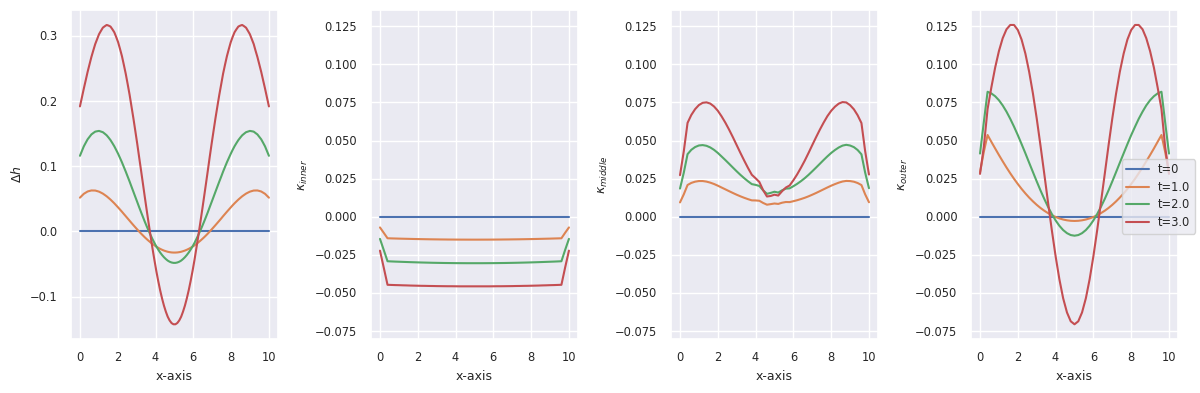

In [25]:
from utils.trilayer_visu import plot_buckling_monitoring

fig = plot_buckling_monitoring(data_monitoring)
fig.tight_layout()

* $\Delta h$ is the variation of height between the reference and current state
* $\kappa_{inner}$ is the curvature of the inner surface
* $\kappa_{outer}$ is the curvature of the outer surface
* $\kappa_{middle}$ is the curvature of the middle of the tissue in the current state

## Parameter space exploration & Data analysis

Using the script `run_multiprocessing_buckling_simulation`, the buckling effect was studied for the following range of parameters : 

* E_i (young modulus of the inner layer) : [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
* E_o (young modulus of the outer layer) : [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
* h (height of the inner/outer layer) : [0.1, 0.2, 0.3, 0.4]

for a total of 7x7x4 = 196 distincts simulations.

The data (parameters + buckling monitoring) corresponding to the parameter exploration are stored in a .csv file `buckling_parameter_exploration` that can be opened using `read_csv_simulation`.

In [26]:
from utils.trilayer_analysis import read_csv_simulation

data_filename = 'buckling_parameter_exploration.csv'
root_directory = 'data/'

df = read_csv_simulation(data_filename, root_directory=root_directory)

In [27]:
df.head(2)

L   cs  Nsteps  tmax  imperfection  geo_pertub_norm  CI_perturbation    H  \
0  10  0.2       3     3             0                0           0.0001  4.2   
1  10  0.2       3     3             0                0           0.0001  4.2   

     h        E_i  ...  dg_e  time  \
0  0.4  1000000.0  ...     0  0.00   
1  0.4  1000000.0  ...     0  0.25   

                                                x_dH  \
0  [0.0, 0.10101318, 0.20202637, 0.30297852, 0.40...   
1  [0.0, 0.10101318, 0.20202637, 0.30297852, 0.40...   

                                                  dH  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.01192474, 0.013237, 0.01454163, 0.01540375,...   

                                       x_kappa_inner  \
0  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   
1  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   

                                         kappa_inner  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [-0.00102901, -0.0015831, -0.00214958, -0.0021...   

                                       x_kappa_outer  \
0  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   
1  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   

                                         kappa_outer  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0120163, 0.01241302, 0.00735092, 0.0020752,...   

                                      x_kappa_middle  \
0  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   
1  [0.0, 0.19995117, 0.39990234, 0.60009766, 0.79...   

                                        kappa_middle  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.00084591, 0.00145245, 0.00227356, 0.0025672...  

[2 rows x 38 columns]

In [28]:
df.columns

Index(['L', 'cs', 'Nsteps', 'tmax', 'imperfection', 'geo_pertub_norm',
       'CI_perturbation', 'H', 'h', 'E_i', 'E_m', 'E_o', 'E_e', 'C_i', 'C_m',
       'C_o', 'C_e', 'nu_i', 'nu_m', 'nu_o', 'nu_e', 'g_i', 'g_m', 'g_o',
       'g_e', 'dg_i', 'dg_m', 'dg_o', 'dg_e', 'time', 'x_dH', 'dH',
       'x_kappa_inner', 'kappa_inner', 'x_kappa_outer', 'kappa_outer',
       'x_kappa_middle', 'kappa_middle'],
      dtype='object')

The dataframe contains the different parameters (`L`, `cs`,...) and variables that monitor the emergence of buckling (`kappa` and `dH`).

### Create one data file containing the main outputs of all the simulations in the exploration

If needed, the .csv file corresponding to a given parameter exploration can be created using `update_simulation_data`. 

In [29]:
from utils.trilayer_analysis import update_simulation_data

# - This will automatically extract (or update) the simulation information from a root_directory path
df = update_simulation_data(data_filename, root_directory=root_directory)

### Update the data file by computing mean curvature and number of curvature extrema on surfaces

The occurrence of buckling in the growing tissue is related to the appearance of bumps on the surface. Whether bumps appear on the surface, can be detected following the variation of tissue height and curvatures along the layers. The `compute_mean_curvature_and_extrema` tool gives the number of extrema (local maximum/minimum) in the different variables (tissue height, curvature of the inner and outer surface) that monitor the buckling. The mean curvature will also be computed.

In [30]:
from utils.trilayer_analysis import compute_mean_curvature_and_extrema

THRESHOLD_PEAK_CURVATURE = 0.05 # minimal height to detect peak
THRESHOLD_PEAK_HEIGHT = 0.1 # minimal height to detect peak

# - This will automatically compute the number of extrema (minimum & maximum) from the layer's curvature & variation of the height of the tissue
df = compute_mean_curvature_and_extrema(data_filename, kappa_rel_height=THRESHOLD_PEAK_CURVATURE, dh_rel_height=THRESHOLD_PEAK_HEIGHT,
                                       root_directory=root_directory, col_names = 'kappa_')

In [31]:
df.columns

Index(['L', 'cs', 'Nsteps', 'tmax', 'imperfection', 'geo_pertub_norm',
       'CI_perturbation', 'H', 'h', 'E_i', 'E_m', 'E_o', 'E_e', 'C_i', 'C_m',
       'C_o', 'C_e', 'nu_i', 'nu_m', 'nu_o', 'nu_e', 'g_i', 'g_m', 'g_o',
       'g_e', 'dg_i', 'dg_m', 'dg_o', 'dg_e', 'time', 'x_dH', 'dH',
       'x_kappa_inner', 'kappa_inner', 'x_kappa_outer', 'kappa_outer',
       'x_kappa_middle', 'kappa_middle', 'mean_inner', 'num_maxima_inner',
       'num_minima_inner', 'mean_outer', 'num_maxima_outer',
       'num_minima_outer', 'mean_middle', 'num_maxima_middle',
       'num_minima_middle', 'num_maxima_dH', 'num_minima_dH'],
      dtype='object')

### Visualize the number of curvature maxima in outer layer

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme() # activate the seaborn's "default" theme

displayed_times = [0, 1, 2] # select only some time-steps
df = df[df.time.isin(displayed_times)].copy() # filter the dataframe

In [33]:
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
import itertools

Nt=np.unique(df['Nsteps'])[0]
fs = 20

def plot_heatmap_grille(df, x, y, variable, title, filename=None, annot=False, fmt=".0f", cmap='inferno', font_scale=1, vmax=None, vmin=None):

    # - Define columns (time)
    t_list = sorted(df.time.unique()) # unique times
    Nt = len(t_list) # number of columns

    # - Define rows (h)
    h_list = sorted(df.h.unique()) # unique heights
    Nh = len(h_list)
    
    fig, axs = plt.subplots(Nh, Nt, figsize=( 1.5*(Nt+1), 2*Nh))
    fig.suptitle(title)    
    sns.set(font_scale = font_scale)
                  
    # Identify all the unique X and Y values
    all_x = df[x].unique()
    all_y = df[y].unique()
    ref_df = pd.DataFrame(list(itertools.product(all_x, all_y)), columns=[x, y]) # create a reference df (to avoid missing values)

    if vmin is None:
        vmin = df[variable].values.min() # get the min value of the col

    if vmax is None:
        vmax = df[variable].values.max() # get the max value of the col

    ticks = None
    tick_labels = None
    if (df[variable].dtype == np.int64):
        # - create cmap
        cmap = plt.cm.get_cmap(cmap, vmax+1)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = ListedColormap(cmap)
        ticks = np.linspace(0.5, vmax+0.5, vmax+1) # centered the ticks
        tick_labels = list(range(vmax+1))
        vmax+=1

    for i in range(Nt):
        for j in range(Nh):
            dataframe = df.loc[df['time']==t_list[i]].loc[df['h']==h_list[j]]
            dataframe = pd.merge(ref_df, dataframe, on=[x, y], how='left') # make sure we plot all the X and Y values (even if missing)
            data = ( dataframe.pivot(index=y, columns=x, values=variable) )
            yticklabels, xticklabels = True, True
            if dataframe.shape[0]>0 :
                # - add xlabel & ylabels ?
                if i != 0:
                    yticklabels=False

                if j != Nh-1:
                    xticklabels=False
                
                sns.heatmap(data, annot=annot, fmt=fmt, linewidths=.5, ax=axs[j,i],
                            cbar=False, vmin=vmin, vmax=vmax, cmap=cmap, annot_kws = {'fontsize':font_scale*12}, 
                            yticklabels=yticklabels, xticklabels=xticklabels)

                if not yticklabels:
                    axs[j, i].set(ylabel=None)
                else:
                    s = axs[j, i].get_ylabel()
                    axs[j, i].set_ylabel(f"${s}$") # LateX
                if not xticklabels:
                    axs[j, i].set(xlabel=None)
                else:
                    s = axs[j, i].get_xlabel()
                    axs[j, i].set_xlabel(f"${s}$") # LateX
                
            axs[j,i].set_title("t="+str(t_list[i])+" h="+str(h_list[j])) 
            

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
    cb = fig.colorbar(axs[0, Nt-1].collections[0], cax=cbar_ax, ticks=ticks)

    if tick_labels is not None:
        cb.set_ticks(ticks=ticks, labels=tick_labels)

    if filename is not None:
        fig.savefig(filename, dpi=200, bbox_inches='tight')
        
    return fig

/tmp/ipykernel_1449508/3371736560.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap, vmax+1)


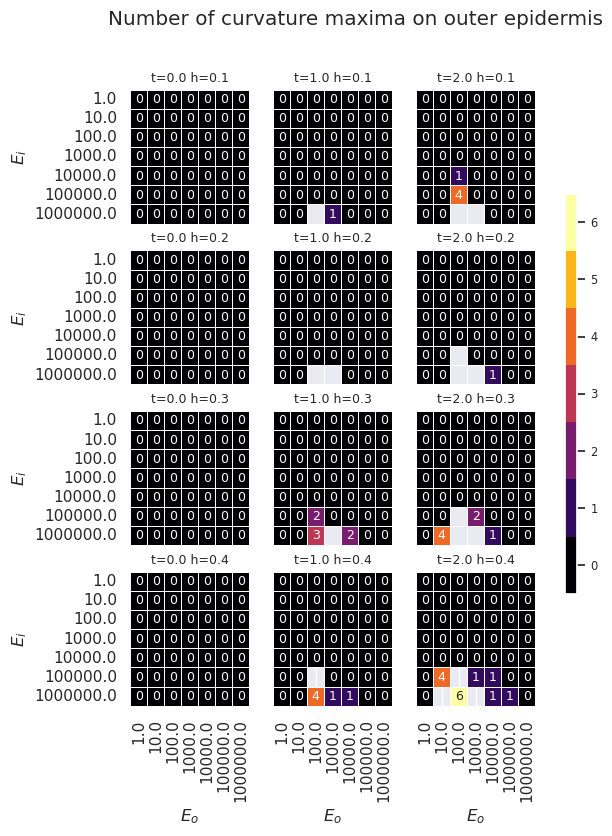

In [34]:
fig = plot_heatmap_grille(df, "E_o", "E_i", "num_maxima_outer", "Number of curvature maxima on outer epidermis", annot=True, font_scale=0.75)

### Visualize the mean midheight curvature

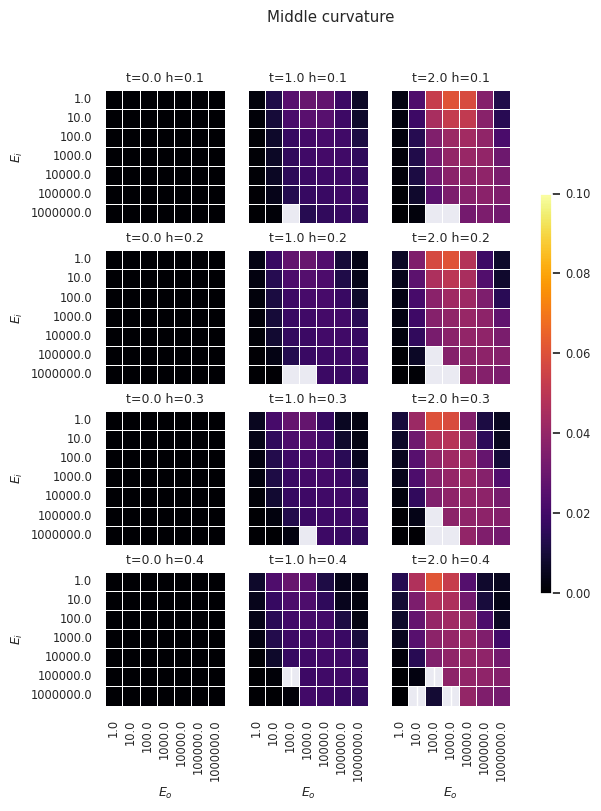

In [35]:
fig = plot_heatmap_grille(df, "E_o", "E_i", "mean_middle", "Middle curvature", vmax=0.1, font_scale=0.75)

### Visualize the curvature predicted by the analytical model of a growing trilayer

An approximate theoretical curvature can be computed and compare to the measured one.

In [36]:
def curvature(Ei, Eo, Em, gi, go, gm, h, hm):
    # - Compute the curvature of the trilayer
    A = 1 / (4 * Ei * Eo * h + Em * (Ei + Eo) * hm) # Eq [...]
    return (2 * A) / (h + hm) * (2 * Ei * Eo * h * (go - gi) + Em * Eo * hm * (go - gm) - Em * Ei * hm * (gi - gm)) # Eq [...]

In [37]:
# - Compute the theoretical curvature of the tissue
df['c_model'] = curvature(df['E_i'], df['E_o'], df['E_m'],
                          df['dg_i']*df['time'], df['dg_o']*df['time'], df['dg_m']*df['time'],
                          df['h'], df['H'])
#df['c_error'] = -(df['mean_middle']-df['c_model']) # compare with the curvature calculated at the middle of the tissue

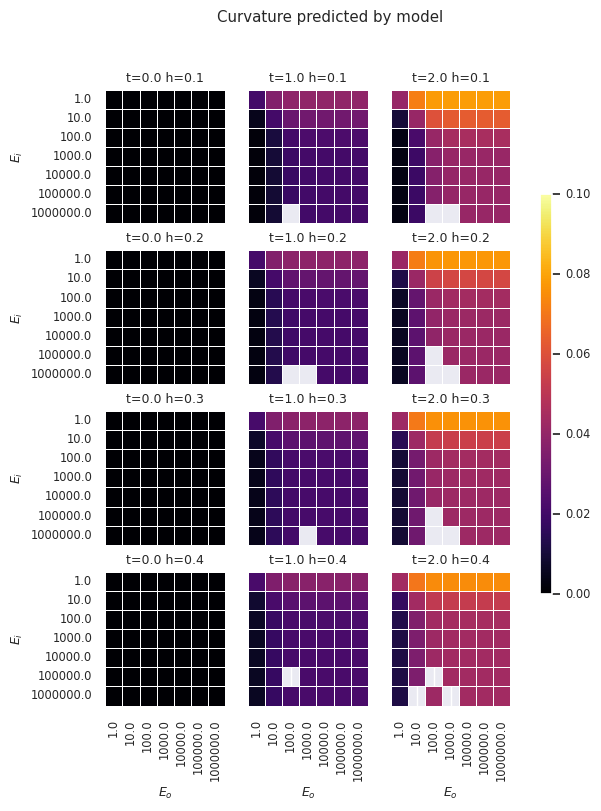

In [38]:
fig = plot_heatmap_grille(df, "E_o", "E_i", "c_model", "Curvature predicted by model", vmax=0.1, font_scale=0.75)